# Задача классификации рукописных арабских цифр
## _С помощью кластеризации и свёрточного автоэнкодера для снижения размерности данных_

In [1]:
import numpy
import time
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets # load_digits()
import sklearn.cluster # KMeans
import sklearn.metrics

import math

%matplotlib inline

## 1. Загрузка данных

In [2]:
digits = sklearn.datasets.load_digits()
data = digits['data']
labels = digits['target']

In [3]:
data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [4]:
len(data), len(data[0])

(1797, 64)

Посмотрим минимальные и максимальные значение пикселей:

In [5]:
min([min(v) for v in data]), max([max(v) for v in data])

(0.0, 16.0)

А также метки и их количество:

In [6]:
labels, sorted(set(labels))

(array([0, 1, 2, ..., 8, 9, 8]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
len(labels)

1797

__Итак, в размеченном наборе данных всего 1797 цифр, каждая представлена одномерным массивом из 64 элементов (8x8 пикселей)__.

Так они выглядят (первые 50 изображений).

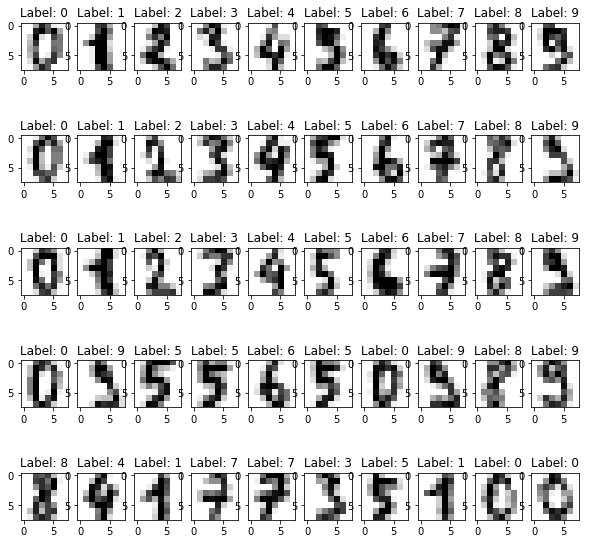

In [8]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Label: {labels[i]}')

## 2. Используемые методы (немного матана)

### Алгоритм K-Means:
K-Means это один из самых используемых алгоритмов кластеризации.
По данным и числу кластеров $k$, он итеративно вычисляет распределение объектов по k кластерам {$S_1, \dots, S_k$} и центры кластеров, минимизируя суммарное расстояние от центров кластеров до объектов, которые к ним относятся:

$$\sum\limits_{i=1}^{k} \sum\limits_{j:x_j\in S_i}^n\|x_j-m_i\|^2$$
Где $k$ число кластеров, $n$ число объектов, $S_i$ это $i$-ый кластер с центром в  $m_i$, $x_j$ это $j$-ый объект.

### Автоэнкодеры:

Автоэнкодеры — это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой код, описывающий модель. Автоэнкодеры конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе.

Автоэнкодеры состоят из двух частей: энкодера $g$ и декодера $f$. Энкодер переводит входной сигнал в его представление (код): $h=g(x)$, а декодер восстанавливает сигнал по его коду: $x=f(h)$.

Автоэнкодер, изменяя $f$ и $g$, стремится выучить тождественную функцию $x=f(g(x))$, минимизируя какой-то функционал ошибки: $L(x, f(g(x))$.

1. https://blog.keras.io/building-autoencoders-in-keras.html
1. https://habr.com/post/331382/
1. https://keras.io/layers/convolutional/#conv2d

In [9]:
%%html
<img src="http://localhost:8888/files/Projects/ml/examples/autoencoder.png"/>

## 3. Уменьшим размерность с помощью автоэнкодера

В этом случае будем использовать также нейронную сеть прямого распространения, только с большим количеством слоёв.

In [34]:
from keras.layers import Input, Dense
from keras.models import Model

In [35]:
# input placeholder
input_image = Input(shape=(64,))
# encoded input from 64 to 32
encoded = Dense(32, activation='relu')(input_image)
# encoded previous layer from 32 to 16
encoded = Dense(16, activation='relu')(encoded)
# encoded previous layer from 16 to 4
encoded = Dense(4, activation='relu')(encoded)

# reconstruction of the encoded back from 4 to 16
decoded = Dense(16, activation='relu')(encoded)
# reconstruction of the previous layer back from 16 to 32
decoded = Dense(32, activation='relu')(decoded)
# reconstruction of the previous layer back from 32 to 64
decoded = Dense(64, activation='sigmoid')(decoded)

# autoencoder model 64 to 64 with losses
autoencoder = Model(input_image, decoded, name='autoencoder')

encoder = Model(input_image, encoded, name='encoder')

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [36]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
Total para

In [37]:
norm_data = data.astype('float32') / 16.0
len(norm_data), len(norm_data[0])

(1797, 64)

In [38]:
%%time
autoencoder.fit(norm_data, norm_data, epochs=500, batch_size=128, shuffle=True)

Epoch 1/500
1797/1797 [==============================] - 1s 789us/step - loss: 0.6919
Epoch 2/500
1797/1797 [==============================] - 0s 81us/step - loss: 0.6860
Epoch 3/500
1797/1797 [==============================] - 0s 90us/step - loss: 0.6759
Epoch 4/500
1797/1797 [==============================] - 0s 83us/step - loss: 0.6438
Epoch 5/500
1797/1797 [==============================] - 0s 123us/step - loss: 0.5427
Epoch 6/500
1797/1797 [==============================] - 0s 87us/step - loss: 0.4578
Epoch 7/500
1797/1797 [==============================] - 0s 87us/step - loss: 0.4318
Epoch 8/500
1797/1797 [==============================] - 0s 93us/step - loss: 0.4257
Epoch 9/500
1797/1797 [==============================] - 0s 55us/step - loss: 0.4245
Epoch 10/500
1797/1797 [==============================] - 0s 25us/step - loss: 0.4234
Epoch 11/500
1797/1797 [==============================] - 0s 23us/step - loss: 0.4234
Epoch 12/500
1797/1797 [==============================] - 0s 

1797/1797 [==============================] - 0s 24us/step - loss: 0.3603
Epoch 191/500
1797/1797 [==============================] - 0s 21us/step - loss: 0.3598
Epoch 192/500
1797/1797 [==============================] - 0s 22us/step - loss: 0.3600
Epoch 193/500
1797/1797 [==============================] - 0s 24us/step - loss: 0.3601
Epoch 194/500
1797/1797 [==============================] - 0s 29us/step - loss: 0.3599
Epoch 195/500
1797/1797 [==============================] - 0s 28us/step - loss: 0.3598
Epoch 196/500
1797/1797 [==============================] - 0s 24us/step - loss: 0.3594
Epoch 197/500
1797/1797 [==============================] - 0s 29us/step - loss: 0.3595
Epoch 198/500
1797/1797 [==============================] - 0s 26us/step - loss: 0.3595
Epoch 199/500
1797/1797 [==============================] - 0s 29us/step - loss: 0.3593
Epoch 200/500
1797/1797 [==============================] - 0s 29us/step - loss: 0.3591
Epoch 201/500
1797/1797 [==============================] 

1797/1797 [==============================] - 0s 26us/step - loss: 0.3412
Epoch 379/500
1797/1797 [==============================] - 0s 31us/step - loss: 0.3414
Epoch 380/500
1797/1797 [==============================] - 0s 23us/step - loss: 0.3413
Epoch 381/500
1797/1797 [==============================] - 0s 29us/step - loss: 0.3414
Epoch 382/500
1797/1797 [==============================] - 0s 36us/step - loss: 0.3411
Epoch 383/500
1797/1797 [==============================] - 0s 28us/step - loss: 0.3412
Epoch 384/500
1797/1797 [==============================] - 0s 26us/step - loss: 0.3411
Epoch 385/500
1797/1797 [==============================] - 0s 29us/step - loss: 0.3409
Epoch 386/500
1797/1797 [==============================] - 0s 32us/step - loss: 0.3408
Epoch 387/500
1797/1797 [==============================] - 0s 32us/step - loss: 0.3408
Epoch 388/500
1797/1797 [==============================] - 0s 28us/step - loss: 0.3410
Epoch 389/500
1797/1797 [==============================] 

In [39]:
data_reduced = encoder.predict(norm_data)
len(data_reduced), len(data_reduced[0])

(1797, 4)

__Таким образом, от элементов размера 64 мы перешли к элементам меньшей размерности (в данном случае, размерность равна 4)__.

## 4. Кластеризация с помощью алгоритма K-means 

In [40]:
%%time
kmeans = sklearn.cluster.KMeans(n_clusters=10, max_iter=1000, tol=0, n_jobs=-1)
kmeans.fit(data_reduced)

Wall time: 6.29 s


Посмотрим теперь, как разложились входные данные по кластерам. Если построить гистограмму (можно мысленно), то легко оценить качество получившегося разбиения по входным меткам.

In [41]:
cluster_mapping = {i: [0 for j in range(10)] for i in range(10)}
for l, k in zip(labels, kmeans.labels_):
    cluster_mapping[l][k] += 1
cluster_mapping  

{0: [0, 5, 0, 0, 0, 0, 0, 0, 7, 166],
 1: [72, 0, 13, 15, 28, 0, 19, 16, 3, 16],
 2: [1, 1, 14, 3, 3, 35, 2, 105, 11, 2],
 3: [0, 0, 0, 7, 9, 110, 11, 4, 41, 1],
 4: [3, 121, 1, 10, 20, 0, 18, 0, 0, 8],
 5: [0, 6, 0, 39, 3, 5, 42, 0, 63, 24],
 6: [1, 10, 133, 0, 0, 0, 0, 33, 3, 1],
 7: [0, 1, 0, 66, 32, 0, 72, 0, 0, 8],
 8: [1, 2, 5, 13, 35, 42, 40, 8, 26, 2],
 9: [0, 0, 0, 15, 0, 10, 3, 0, 111, 41]}

Итак, можно предположить по принципу простого большинства такое прямое соответствие:

In [42]:
for k, v in cluster_mapping.items():
    print(f'{k} <= {v.index(max(v))}')

0 <= 9
1 <= 0
2 <= 7
3 <= 5
4 <= 1
5 <= 8
6 <= 2
7 <= 6
8 <= 5
9 <= 8


__Оценим качество кластеризации *как полагается* по науке__

- Homogenity: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- Completeness: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html
- V-Measure: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

In [43]:
print("Homogeneity: %0.3f" % sklearn.metrics.homogeneity_score(labels, kmeans.labels_))
print("Completeness: %0.3f" % sklearn.metrics.completeness_score(labels, kmeans.labels_))
print("V-measure: %0.3f" % sklearn.metrics.v_measure_score(labels, kmeans.labels_))

Homogeneity: 0.447
Completeness: 0.457
V-measure: 0.452


Прямо скажем, не очень. На самом деле, вот это самое "не очень" хорошо видно уже из таблички **cluster_mapping**, которая была подсчитана выше.

## 5. Тестовая картинка с цифрой 0, которую мы попытаемся распознать

In [44]:
img = plt.imread('0_small.png')

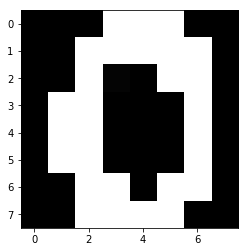

In [45]:
plt.imshow(img, cmap='gray')

In [46]:
len(img), len(img[0]), len(img[0][0])

(8, 8, 3)

Видно, что загруженная PNG картинка устроена по-другому, не так как тестовый набор __digits__ в __sklearn__: это двумерный массив 8x8, каждый элемент которого это RGB-тройка, причем компоненты RGB - это числа с плавающей точкой от 0 до 1. А `sklearn.datasets.load_digits()` возвращает пиксели как число от 0 до 16 (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).
Таким образом, нам надо свернуть (R,G,B) в одно число с максимальным значением 16. Сделаем это, например, так:

In [47]:
transformed_img = list()
for line in img:
    for pixel in line:
        com_r = pixel[0]
        com_g = pixel[1]
        com_b = pixel[2]
        transformed_img.append(int(math.sqrt(com_r**2 + com_g**2 + com_b**2) * 16 / math.sqrt(3)))

Редуцируем размерность внутренним слоем автоэнкодера:

In [48]:
d = encoder.predict(numpy.array([transformed_img]))
d

array([[ 0.9520494, 50.978138 ,  4.070531 , 29.245771 ]], dtype=float32)

Предсказываем наиболее подходящий номер кластера:

In [49]:
r = kmeans.predict(d)
r

array([0])

Попадание.
Теперь проверим цифры из набора.

In [50]:
d = encoder.predict(numpy.array([norm_data[0]]))
d

array([[0.       , 4.74295  , 1.9903542, 1.9638915]], dtype=float32)

In [51]:
kmeans.predict(d)

array([9])

Правильное предположение. И ещё одна попытка (случайный выбор):

In [52]:
d = encoder.predict(numpy.array([norm_data[16]]))
d

array([[ 0.       , 28.175602 ,  3.7011073, 12.498037 ]], dtype=float32)

In [53]:
kmeans.predict(d)

array([7])

А вот мимо. Возьмём ещё цифру:

In [54]:
d = encoder.predict(numpy.array([norm_data[12]]))
d

array([[ 0.       , 18.32418  ,  1.2947202, 12.236655 ]], dtype=float32)

In [55]:
kmeans.predict(d)

array([2])

Вывод закономерен: количество слоёв нейронной сети прямого распространения практически не помогает для такого рода зача (работа с изображениями). Нужно систему менять.